In [166]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, precision_score, recall_score
import pyspark
from pyspark.sql import SparkSession, SQLContext,HiveContext, functions as F

In [2]:
spark=SparkSession.builder.appName('kpop').getOrCreate()
spark

In [3]:
data = pd.read_csv('Final database.csv')

c:\Users\Albert\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (7,8,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
kpop=data[data["Genre"]=="k-pop"]
kpop

,Country,Uri,Popularity,Title,Artist,Album/Single,Genre,Artist_followers,Explicit,Album,...,Sweden,Switzerland,Taiwan,Turkey,UK,USA,Popu_max,Top10_dummy,Top50_dummy,Cluster
279,Global,https://open.spotify.com/track/0usLRFLmYXYahKN...,183.7,trivia 起 : just dance,BTS,album,k-pop,24755789.0,False,Love Yourself 結 'Answer',...,0,0,0,0,0,0,79,0.0,0.0,global
280,USA,https://open.spotify.com/track/0usLRFLmYXYahKN...,69.6,trivia 起 : just dance,BTS,album,k-pop,24755789.0,False,Love Yourself 結 'Answer',...,0,0,0,0,0,1,118,0.0,0.0,english speaking and nordic
281,UK,https://open.spotify.com/track/0usLRFLmYXYahKN...,11.2,trivia 起 : just dance,BTS,album,k-pop,24755789.0,False,Love Yourself 結 'Answer',...,0,0,0,0,1,0,187,0.0,0.0,english speaking and nordic
282,Argentina,https://open.spotify.com/track/0usLRFLmYXYahKN...,72.8,trivia 起 : just dance,BTS,album,k-pop,24755789.0,False,Love Yourself 結 'Answer',...,0,0,0,0,0,0,110,0.0,0.0,spanish speaking
283,Brazil,https://open.spotify.com/track/0usLRFLmYXYahKN...,4.8,trivia 起 : just dance,BTS,album,k-pop,24755789.0,False,Love Yourself 結 'Answer',...,0,0,0,0,0,0,195,0.0,0.0,southern europe and portuguese heritage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170531,Taiwan,https://open.spotify.com/track/13o3rRMgTlLtkhy...,28.0,downpour,I.O.I,single,k-pop,945799.0,False,DOWNPOUR,...,0,0,1,0,0,0,166,0.0,0.0,english speaking and nordic
170576,Taiwan,https://open.spotify.com/track/6N0uDUUQRQd7lII...,612.1,hold me,Eric Nam,single,k-pop,861781.0,False,Hold Me,...,0,0,1,0,0,0,45,0.0,1.0,english speaking and nordic
170585,Taiwan,https://open.spotify.com/track/3faO4pLbvIOi8zM...,0.8,bdz - korean ver.,TWICE,album,k-pop,6954833.0,False,YES or YES,...,0,0,1,0,0,0,200,0.0,0.0,english speaking and nordic
170602,Taiwan,https://open.spotify.com/track/2xdemMCz1rTkrDd...,60.0,gone cold,MXM,single,k-pop,180147.0,False,REMATCH,...,0,0,1,0,0,0,126,0.0,0.0,english speaking and nordic


In [5]:
df = (spark.read.format("csv").options(header="true")
    .load('Final database.csv'))

In [6]:
kpop = df.filter(df.Genre == "k-pop")

In [7]:
kpop

DataFrame[Country0: string, Uri: string, Popularity: string, Title: string, Artist: string, Album/Single: string, Genre: string, Artist_followers: string, Explicit: string, Album9: string, Release_date: string, Track_number: string, Tracks_in_album: string, danceability: string, energy: string, key: string, loudness: string, mode: string, speechiness: string, acoustics: string, instrumentalness: string, liveliness: string, valence: string, tempo: string, duration_ms: string, time_signature: string, Genre_new: string, Days_since_release: string, Released_after_2017: string, Explicit_false: string, Explicit_true: string, album31: string, compilation: string, single: string, bolero: string, boy band: string, country36: string, dance/electronic: string, else: string, funk: string, hip hop: string, house: string, indie: string, jazz: string, k-pop: string, latin: string, metal: string, opm: string, pop: string, r&b/soul: string, rap: string, reggae: string, reggaeton: string, rock: string, 

In [8]:
kpop.createOrReplaceTempView("kpop")

In [9]:
spark.sql("SELECT Artist,Count(*) FROM kpop group by Artist order by count(*) desc limit 10").show()

+--------------------+--------+
|              Artist|count(1)|
+--------------------+--------+
|                 BTS|    1376|
|           BLACKPINK|     381|
|               TWICE|     196|
|                 EXO|     137|
|             TAEYEON|      98|
|          Red Velvet|      68|
|           SEVENTEEN|      62|
|BLACKPINK - Selen...|      62|
| TOMORROW X TOGETHER|      59|
|                  IU|      54|
+--------------------+--------+



In [10]:
result_df = (kpop.groupBy("Artist")
               .count()
               .orderBy("count", ascending=False)
               .limit(10)
               .toPandas()
            )

In [11]:
color_dict = dict({'BTS':'midnightblue',
                  'BLACKPINK':'lightpink',
                  'TWICE': 'darkmagenta',
                  'EXO': 'gold',
                   'TAEYEON': 'peru',
                   'Red Velvet':'orangered',
                  'SEVENTEEN':'paleturquoise',
                  'BLACKPINK - Selena Gomez': 'hotpink',
                  'TOMORROW X TOGETHER': 'forestgreen',
                   'IU': 'springgreen',
                   })

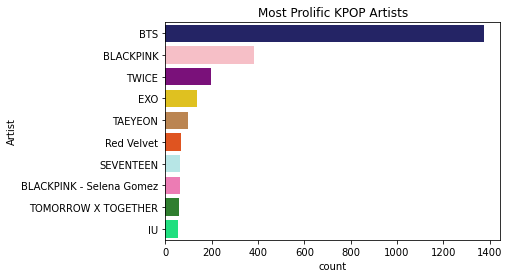

In [13]:
sns.barplot(data=result_df, y='Artist', x='count',palette=color_dict).set_title('Most Prolific KPOP Artists');

In [16]:
query_df= spark.sql(f"SELECT Artist,Avg(danceability) FROM kpop group by Artist order by count(*) desc limit 10")
query_df.show()

+--------------------+------------------+
|              Artist| avg(danceability)|
+--------------------+------------------+
|                 BTS|0.6297565406976738|
|           BLACKPINK|0.6993149606299215|
|               TWICE|0.6996428571428571|
|                 EXO|0.6507664233576644|
|             TAEYEON|0.5347244897959181|
|          Red Velvet|0.7042647058823531|
|           SEVENTEEN|0.6879838709677419|
|BLACKPINK - Selen...|0.7878225806451609|
| TOMORROW X TOGETHER|0.6386440677966101|
|                  IU|0.5780925925925927|
+--------------------+------------------+



Text(0.5, 1.0, 'Average Danceability of Top 10 Artists')

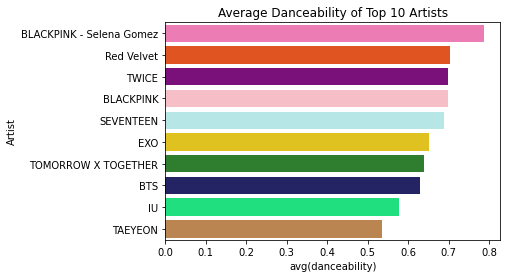

In [17]:
query=query_df.toPandas()
query=query.sort_values(by=['avg(danceability)'],ascending=False)
sns.barplot(data=query, y='Artist', x='avg(danceability)',palette=color_dict).set_title('Average Danceability of Top 10 Artists')

In [18]:
query_df=spark.sql(f"SELECT Artist,Avg(energy) FROM kpop group by Artist order by count(*) desc limit 10")
query_df.show()

+--------------------+------------------+
|              Artist|       avg(energy)|
+--------------------+------------------+
|                 BTS|0.7552209302325578|
|           BLACKPINK|0.7481259842519681|
|               TWICE| 0.847290816326531|
|                 EXO|0.7173138686131382|
|             TAEYEON|0.6529081632653063|
|          Red Velvet|0.8311323529411767|
|           SEVENTEEN|0.8067419354838712|
|BLACKPINK - Selen...|0.7246451612903222|
| TOMORROW X TOGETHER|0.7789661016949153|
|                  IU|0.5289074074074074|
+--------------------+------------------+



Text(0.5, 1.0, 'Average Energy of Top 10 Artists')

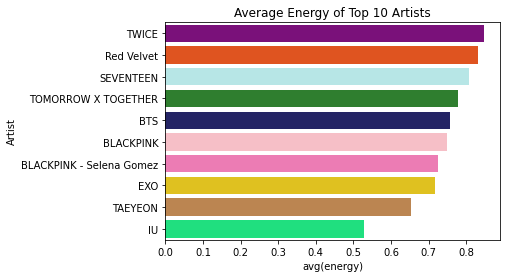

In [19]:
query=query_df.toPandas()
query=query.sort_values(by=['avg(energy)'],ascending=False)
sns.barplot(data=query, y='Artist', x='avg(energy)',palette=color_dict).set_title('Average Energy of Top 10 Artists')

In [20]:
query_df=spark.sql(f"SELECT Artist,Avg(Artist_followers) FROM kpop group by Artist order by count(*) desc limit 10")
query_df.show()

+--------------------+---------------------+
|              Artist|avg(Artist_followers)|
+--------------------+---------------------+
|                 BTS|          2.4755789E7|
|           BLACKPINK|          1.6413563E7|
|               TWICE|            6954833.0|
|                 EXO|            6731265.0|
|             TAEYEON|            1578572.0|
|          Red Velvet|            4250504.0|
|           SEVENTEEN|            4343407.0|
|BLACKPINK - Selen...|          1.6413563E7|
| TOMORROW X TOGETHER|            2330479.0|
|                  IU|            2549946.0|
+--------------------+---------------------+



Text(0.5, 1.0, 'Followers of Top 10 Artists')

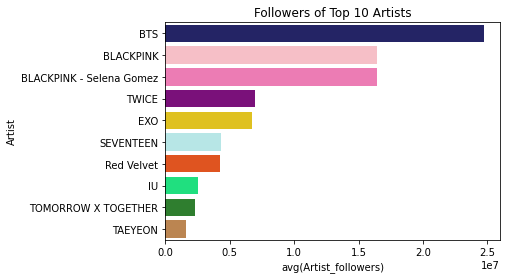

In [22]:
query=query_df.toPandas()
query=query.sort_values(by=['avg(Artist_followers)'],ascending=False)
query
sns.barplot(data=query, y='Artist', x='avg(Artist_followers)',palette=color_dict).set_title('Followers of Top 10 Artists')

In [175]:
kpopp = kpop.toPandas()

In [176]:
kpopp=kpopp[['Popularity','Album/Single','Artist_followers','Explicit','danceability','energy','key','loudness','speechiness','acoustics','instrumentalness','liveliness','valence','tempo','time_signature','Days_since_release',
             'Released_after_2017']]
kpopp

,Popularity,Album/Single,Artist_followers,Explicit,danceability,energy,key,loudness,speechiness,acoustics,instrumentalness,liveliness,valence,tempo,time_signature,Days_since_release,Released_after_2017
0,183.7,album,24755789.0,False,0.723,0.906,1,-4.7780000000000005,0.279,0.0907,0.0,0.0771,0.398,125.019,4,813.0,1.0
1,69.60000000000001,album,24755789.0,False,0.723,0.906,1,-4.7780000000000005,0.279,0.0907,0.0,0.0771,0.398,125.019,4,813.0,1.0
2,11.2,album,24755789.0,False,0.723,0.906,1,-4.7780000000000005,0.279,0.0907,0.0,0.0771,0.398,125.019,4,813.0,1.0
3,72.8,album,24755789.0,False,0.723,0.906,1,-4.7780000000000005,0.279,0.0907,0.0,0.0771,0.398,125.019,4,813.0,1.0
4,4.800000000000002,album,24755789.0,False,0.723,0.906,1,-4.7780000000000005,0.279,0.0907,0.0,0.0771,0.398,125.019,4,813.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4048,28.0,single,945799.0,False,0.467,0.433,9,-4.073,0.0332,0.66,0.0,0.13,0.333,145.30200000000005,4,1392.0,1.0
4049,612.1,single,861781.0,False,0.392,0.56,1,-7.377999999999999,0.0546,0.486,0.0,0.108,0.21,127.938,3,1053.0,1.0
4050,0.8,album,6954833.0,False,0.722,0.866,1,-2.7110000000000003,0.052000000000000005,0.0154,0.0,0.11,0.659,137.946,4,740.0,1.0
4051,60.0,single,180147.0,False,0.7140000000000001,0.7020000000000001,11,-3.5610000000000004,0.0405,0.174,0.0,0.157,0.612,90.038,4,984.0,1.0


In [177]:
kpopp.dropna(inplace=True)
kpopp["Album/Single"] = kpopp["Album/Single"].astype('category')
kpopp["Album/Single"] = kpopp["Album/Single"].cat.codes
kpopp["Explicit"] = kpopp["Explicit"].astype('category')
kpopp["Explicit"] = kpopp["Explicit"].cat.codes
kpopp=kpopp.apply(pd.to_numeric)
#kpopp=kpopp.drop(['Artist_followers','Days_since_release'],axis=1)
#kpopp.replace([np.inf, -np.inf], np.nan, inplace=True)
#kpopp.fillna(999, inplace=True)

In [178]:
kpopp['Popularity'] = preprocessing.scale(kpopp['Popularity'])
kpopp['Artist_followers'] = preprocessing.scale(kpopp['Artist_followers'])
kpopp['Days_since_release'] = preprocessing.scale(kpopp['Days_since_release'])
kpopp

,Popularity,Album/Single,Artist_followers,Explicit,danceability,energy,key,loudness,speechiness,acoustics,instrumentalness,liveliness,valence,tempo,time_signature,Days_since_release,Released_after_2017
0,-0.305313,0,1.103456,0,0.723,0.906,1,-4.778,0.2790,0.0907,0.0,0.0771,0.398,125.019,4,0.442396,1.0
1,-0.320173,0,1.103456,0,0.723,0.906,1,-4.778,0.2790,0.0907,0.0,0.0771,0.398,125.019,4,0.442396,1.0
2,-0.327779,0,1.103456,0,0.723,0.906,1,-4.778,0.2790,0.0907,0.0,0.0771,0.398,125.019,4,0.442396,1.0
3,-0.319756,0,1.103456,0,0.723,0.906,1,-4.778,0.2790,0.0907,0.0,0.0771,0.398,125.019,4,0.442396,1.0
4,-0.328613,0,1.103456,0,0.723,0.906,1,-4.778,0.2790,0.0907,0.0,0.0771,0.398,125.019,4,0.442396,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4048,-0.325591,2,-1.168894,0,0.467,0.433,9,-4.073,0.0332,0.6600,0.0,0.1300,0.333,145.302,4,1.799637,1.0
4049,-0.249518,2,-1.176912,0,0.392,0.560,1,-7.378,0.0546,0.4860,0.0,0.1080,0.210,127.938,3,1.004983,1.0
4050,-0.329134,0,-0.595411,0,0.722,0.866,1,-2.711,0.0520,0.0154,0.0,0.1100,0.659,137.946,4,0.271276,1.0
4051,-0.321423,2,-1.241965,0,0.714,0.702,11,-3.561,0.0405,0.1740,0.0,0.1570,0.612,90.038,4,0.843239,1.0


In [179]:
#linear regression
#training and testing data with 8:2 ratio
data_train, data_test= train_test_split(kpopp,test_size=0.2,random_state = 12)
Ytrain = data_train['Popularity']
Ytest=data_test['Popularity']
Xtrain = data_train.drop(['Popularity'],axis=1)
Xtest = data_test.drop(['Popularity'],axis=1)

In [180]:
#linear regression
regr = linear_model.LinearRegression()
linmodel = regr.fit(Xtrain,Ytrain)
linmodel
print('Coefficients: \n', linmodel.coef_)
regr_predictions=regr.predict(Xtest)
mse = mean_squared_error(Ytest, regr_predictions)
print('MSE:',mse)

Coefficients: 
 [ 1.11108467e-01  7.62316501e-02  3.36536354e-16  5.15295568e-01
 -1.71846471e-01  1.92393810e-02  5.48884402e-02 -1.83148444e-01
 -3.47029713e-02 -4.40619924e-01 -7.60762558e-02 -9.75258682e-02
 -4.26804405e-04  1.47350369e-01  1.10654443e-02 -1.90175607e-01]
MSE: 0.9622813994409756
